In [60]:
import numpy as np
import cv2 as cv
import os
from sklearn import svm
from skimage.feature import hog
import matplotlib.pyplot as plt
import re

In [61]:
treinamentoDiretorio = "CAPTCHA-10k/treinamento"
labelsDiretorio = "CAPTCHA-10k/labels10k/"
validacaoDiretorio = "CAPTCHA-10k/validacao"

In [62]:
regioes = [35, 65, 95, 125, 155]
tamanhoDaRegiao = 2048

In [63]:
def padding_img(img: np.ndarray, multiply_of: int):
    nLines, nCols = img.shape
    
    pad_row = 0 if nLines % multiply_of == 0 else multiply_of - nLines % multiply_of
    pad_col = 0 if nCols % multiply_of == 0 else multiply_of - nCols % multiply_of

    pad_width = ((0, pad_row), (0, pad_col)) # 
    return np.pad(img, pad_width, mode='maximum') 

In [64]:
def returna_regioes(img, regioes):
    img_regioes = []

    regioes = [5] + regioes + [img.shape[1]]

    for i in range(len(regioes)-1):
        img_regioes.append(img[:, regioes[i]:regioes[i+1]])


    return img_regioes


In [65]:
def myHog(img):
   return hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys',feature_vector=True, channel_axis=None)

In [66]:
def hogTrainingFeatures():
    features = []
    
    files = os.listdir(treinamentoDiretorio)
    
    for file in files:
        filePath = os.path.join(treinamentoDiretorio, file)
        img = cv.imread(filePath, cv.IMREAD_GRAYSCALE)

        imgs = returna_regioes(img, regioes)

        for i in imgs:
            i = padding_img(i, 16)
            if i.size != tamanhoDaRegiao:
                print("Erro todas as regioes precisam ter o mesmo tamanho")
        
        for i in imgs:
            features.append(myHog(i))

    return features



In [67]:

# Retorna as Labels de Treino
def getTrainingLabels():
    labelsArr = []
    files = os.listdir(treinamentoDiretorio)

    for file in files:
        # get the img label
        labelPATH = os.path.join(labelsDiretorio, file[:-4]+'.txt')
        labelFILE = open(labelPATH, 'r')
        label = labelFILE.read()
        labelFILE.close()

        label = label[0:6] if len(label) > 6 else label

        labelsArr += list(label)
    
    return np.asarray(labelsArr)


In [68]:
features = hogTrainingFeatures()
features = np.asarray(features)

labelsArr = getTrainingLabels()


# Training phase
clf = svm.SVC()
clf.fit(features, labelsArr)

SVC()

# Validação


In [69]:
def predictCaptha(model, imgPath):
    # prediz o captcha da imagem 'imgPath' no modelo 'model'
    
    img = cv.imread(imgPath, cv.IMREAD_GRAYSCALE)
    imgs = returna_regioes(img, regioes)


    features = []
    for i in imgs:
        features.append(myHog(i))
    features = np.asarray(features)
    return model.predict(features)
    


In [70]:
def validation(model):
    features = []
    files = os.listdir(validacaoDiretorio)
    
    for file in files:
        filePath = os.path.join(validacaoDiretorio, file)
        img = cv.imread(filePath, cv.IMREAD_GRAYSCALE)

        imgs = returna_regioes(img, regioes)

        for i in imgs:
            i = padding_img(i, 16)
            if i.size != tamanhoDaRegiao:
                print("Erro todas as regioes precisam ter o mesmo tamanho")
        
        for i in imgs:
            features.append(myHog(i))

    features = np.asarray(features)
    predict = model.predict(features)


    labels = []
    files = os.listdir(validacaoDiretorio)

    for file in files:
        # get the img label
        labelPATH = os.path.join(labelsDiretorio, file[:-4]+'.txt')
        labelFILE = open(labelPATH, 'r')
        label = labelFILE.read()
        labelFILE.close()

        label = label[0:6] if len(label) > 6 else label

        labels += list(label)
    labels = np.asarray(labels)


    return (predict, labels)

predict, labels = validation(clf)

# Análise


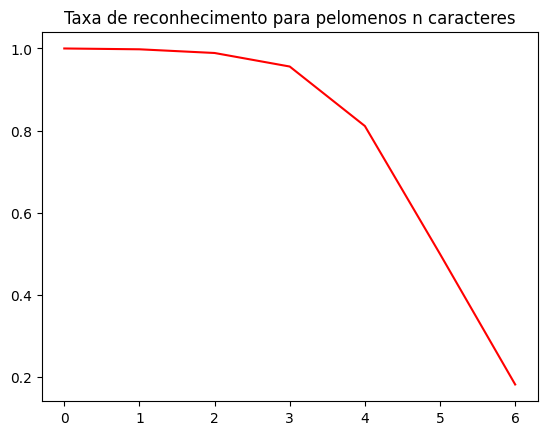

In [71]:
def numOfMatches(strA, strB):
    return (strA == strB).sum()

def createAnalitic(predict, labels):
    numCaptchas = len(labels) // 6

    histogram = [0, 0, 0, 0, 0, 0, 0]

    for i in range(numCaptchas):
        nMatch = numOfMatches(predict[i*6:i*6 + 6], labels[i*6:i*6 + 6])
        for j in range(nMatch + 1):
            histogram[j] += 1
    

    
    X = [0, 1, 2, 3, 4, 5, 6]
    histogram = np.asarray(histogram)
    histogram = histogram / histogram[0]
    plt.plot(X, histogram, '-r')
    plt.title("Taxa de reconhecimento para pelomenos n caracteres")
    plt.show()

createAnalitic(predict, labels)
